In [259]:
# imports
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import json

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2


##### JSON Understanding

Levels : 
- info
  - no use for us
- licenses
  - no use for us
- categories
  - 0 : no tumour
  - 1 : tumour
  - 2 tumour
- images
  - id
  - filename
- annotations
  - id 
  - category id
  - bbox
  - segmentation
  - area
  - iscrowd


In [260]:
data_dir = "/Users/krishuagarwal/Desktop/Programming/python/mlOps/brain-tumour-segmentation/data"
splits = ["train", "test", "valid"]
train_path, test_path, valid_path = [os.path.join(data_dir, split, "_annotations.coco.json") for split in splits]

with open(train_path, "r") as f : 
    train_annotations = json.load(f)

with open(test_path, "r") as f : 
    test_annotations = json.load(f)

with open(valid_path, "r") as f : 
    valid_annotations = json.load(f)
    

train_filenames = [img["id"] for img in train_annotations["images"]]
test_filenames = [img["id"] for img in test_annotations["images"]]
valid_filenames = [img["id"] for img in valid_annotations["images"]]

In [261]:
def useful_json(annotations) :
    useful_ = [] 
    for img in annotations["images"] : 
        img_id = img["id"]
        img_filename = img["file_name"]
        
        for ann in annotations["annotations"] : 
            if img_id == ann["id"] : 
                use = {
                    "id" : img_id,
                    "file_name" : img_filename,
                    "category_id" : ann["category_id"],
                    "bbox" : ann["bbox"],
                    "segmentation" : ann["segmentation"],
                    "area" : ann["area"],
                    "iscrowd" : ann["iscrowd"]
                }
                useful_.append(use)
    return useful_

train_ = useful_json(train_annotations)
test_ = useful_json(test_annotations)
valid_ = useful_json(valid_annotations)

len(valid_)
                        

429

In [327]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, split) : 
        
        self.data_dir = data_dir
        self.split = split
        
        # open the configuration
        annotation_path = os.path.join(self.data_dir, self.split, "_annotations.coco.json")
        with open(annotation_path, "r") as f : 
            self.annotations = json.load(f)
        
        self.annotations_ = self.useful_json()
        self.dir = os.path.join(data_dir, split)
        
        print(f"Loaded split {split} with length : {len(self.annotations_)}")
        
        
    def useful_json(self) :
        useful_ = [] 
        
        # hash map
        img_map = {img["id"]: img for img in self.annotations["images"]}
        
        for ann in self.annotations["annotations"] :
            img_id = ann["image_id"]
            if img_id in img_map:
                img_info = img_map[img_id]
                use = {
                    "id": img_id,
                    "file_name": img_info["file_name"],
                    "category_id": ann["category_id"] - 1,
                    "bbox": ann["bbox"],
                    "segmentation": ann["segmentation"],
                    "area": ann["area"],
                    "iscrowd": ann["iscrowd"]
                }
                useful_.append(use)
                
        return useful_
    

    def __getitem__(self, index):
        ann = self.annotations_[index]
        img, mask = self.draw_mask(index)
        
        mask = torch.from_numpy(mask).long()

        if hasattr(self, "transforms"):
            img = self.transforms(img)
            
        return {
            "image": img, # (1, H, W)
            "mask": mask,
            "category_id": ann["category_id"],
            "file_name": ann["file_name"],
        }
        
    
    def __len__(self):
        return len(self.annotations_)
    
    def draw_mask(self, index):
        img_info = self.annotations_[index]
        img = Image.open(os.path.join(self.dir, img_info["file_name"])).convert("L")
        category_id = img_info["category_id"]
        width, height = img.size
    
        mask = np.zeros((height, width), dtype=np.uint8)
    
        if not img_info["segmentation"]:
            return img, mask
    
        segmentations = img_info["segmentation"]
        for segmentation in segmentations:
            if len(segmentation) % 2 != 0:
                continue
            
            polygon = np.array(segmentation).reshape(-1, 2)
            polygon = polygon.astype(np.int32)
            cv2.fillPoly(mask, [polygon], color=category_id) 
    
        return img, mask
    
    def visualize(self, index) : 
        img, mask = self.draw_mask(index=index)
        img_info = self.annotations_[index]
        img_np = np.array(img)
        
        fig, ax = plt.subplots(1,3, figsize = (15,5))
        
        # plot the original image
        ax[0].imshow(img)
        ax[0].set_title(f"Image: {img_info['file_name']}")
        ax[0].axis("off")
        
        # plot the mask
        ax[1].imshow(mask, cmap = "gray")
        ax[1].set_title(f"Segmentation Mask : Category : {img_info['category_id']}")
        ax[1].axis("off")
        
        colored_mask = np.zeros_like(img_np)
        colored_mask[mask == 1] = [255, 0, 0]
        overlay = cv2.addWeighted(img_np, 1, colored_mask, 1, 0)
        
        ax[2].imshow(overlay)
        ax[2].set_title("Overlay")
        ax[2].axis("off")

        
        plt.tight_layout()
        plt.show()
        
    def create_dataloader(self, batch_size=32, shuffle=True, num_workers=0):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        
        self.transforms = transform
        
        return DataLoader(
            self, 
            batch_size=batch_size, 
            shuffle=shuffle, 
            num_workers=num_workers,
            pin_memory = torch.cuda.is_available()
            )


#### Calculating Dimensions

Convolution : $\frac{W - K + 2P}{S} + 1$

Trans Convolution : $(I - 1) * S - 2P + K$

In [ ]:
class SimpleFCNN(nn.Module) : 
    def __init__(self, lr, epochs, num_classes = 2) : 
        
        super(SimpleFCNN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), # 640 * 640 * 64 
            nn.ReLU(),
            nn.MaxPool2d(2), # 320 * 320 * 64
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 320 * 320 * 128 
            nn.ReLU(),
            nn.MaxPool2d(2), # 160 * 160 * 128
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2), # 160 * 160 * 64
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2), # 160 * 160 * num_classes
        )
        
        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        # self.model_dir = model_dir
        self.epochs = epochs
        
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)
    
    def dice_loss(self, pred, target, smooth=1e-6):
        
        pred = torch.softmax(pred, dim=1)  # softmax over classes
        target_onehot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])
        target_onehot = target_onehot.permute(0, 3, 1, 2).float()  # (N, C, H, W)
    
        intersection = (pred * target_onehot).sum(dim=(2,3))
        union = pred.sum(dim=(2,3)) + target_onehot.sum(dim=(2,3))
    
        dice = (2 * intersection + smooth) / (union + smooth)
        loss = 1 - dice.mean()  # average over batch and classes
    
        return loss
    
    def train_step(self, trainLoaders):
        self.model.train()     
        total_loss = 0
        
        for batch in trainLoaders:
            images = batch["image"].to(self.device)
            masks = batch["mask"].long().to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self(images)
            loss = self.dice_loss(outputs, masks)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss
        
        avg_loss = total_loss / len(trainLoaders)
        return avg_loss
    
        
    def evaluate_step(self, validLoaders):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in validLoaders:
                images = batch["image"].to(self.device)
                masks = batch["mask"].long().to(self.device)
                
                outputs = self(images)
                loss = self.dice(outputs, masks)
                
                total_loss += loss
        
        avg_loss = total_loss / len(validLoaders)
        return avg_loss
        
    def predict(self, testLoaders):
        self.model.eval()
        predictions = []
        
        with torch.no_grad():
            for batch in testLoaders:
                images = batch["image"].to(self.device)
                outputs = self(images)
                _, predicted_masks = torch.max(outputs, dim=1)
                predictions.append(predicted_masks.cpu().numpy())
        
        return np.concatenate(predictions, axis=0)
    
    def train_model(self, trainLoaders, validLoaders):
        for epoch in range(self.epochs):
            train_loss = self.train_step(trainLoaders)
            valid_loss = self.evaluate_step(validLoaders)
            self.save_model()
            return epoch, train_loss, valid_loss
            
            
    def save_model(self):
        torch.save(self.model.state_dict(), self.model_dir)
        print(f"Model saved to {self.model_dir}")


Loaded split train with length : 1502
Loaded split test with length : 215
Loaded split valid with length : 429


ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 0 output values where the mask is true

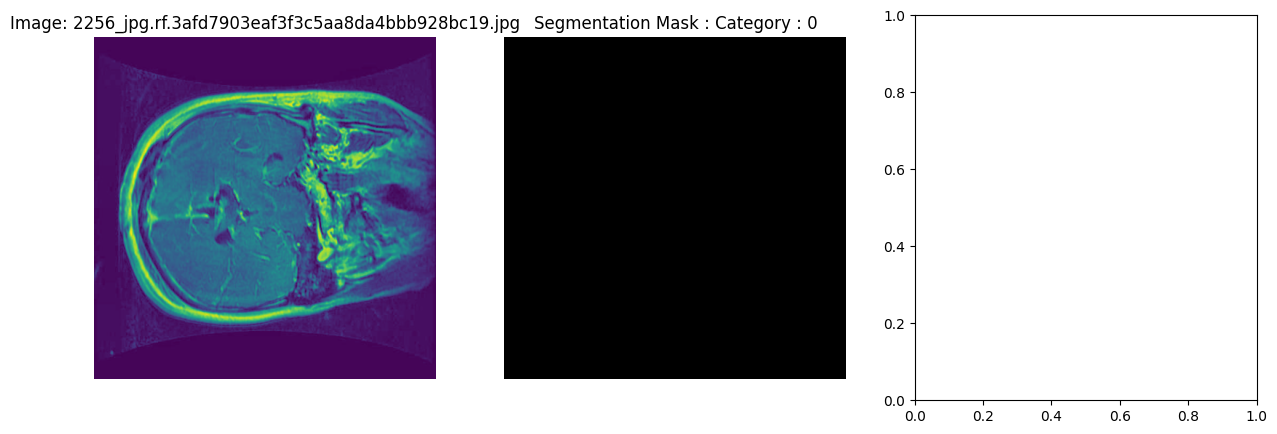

In [344]:
train_ = BrainTumorDataset(data_dir, "train")
test_ = BrainTumorDataset(data_dir, "test")
valid_ = BrainTumorDataset(data_dir, "valid")

train_.visualize(0)



In [337]:
test_dataset = BrainTumorDataset(data_dir, "test")
test_data_loader = test_dataset.create_dataloader(batch_size=1, shuffle=False)

model = SimpleFCNN(lr=0.001, epochs=10)
weights = torch.load("/Users/krishuagarwal/Desktop/Programming/python/mlOps/brain-tumour-segmentation/models/simpleCNN.pth", map_location=model.device)
model.model.load_state_dict(weights)

Loaded split test with length : 215


<All keys matched successfully>

In [338]:
preds = model.predict(test_data_loader)

In [339]:
gt_masks = []
for batch in test_data_loader:
    gt_masks.append(batch["mask"].numpy())
gt_masks = np.concatenate(gt_masks, axis=0)

pixel_accuracy = np.mean(preds == gt_masks)
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

Pixel Accuracy: 0.9897


In [340]:
def visualize_predictions(test_dataset, preds, gt_masks, num_samples=5):

    # Ensure we don't try to visualize more samples than we have
    num_samples = min(num_samples, len(preds))
    
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))
        
        # Plot ground truth
        plt.subplot(1, 3, 1)
        plt.imshow(gt_masks[i], cmap="gray")
        plt.title(f"Ground Truth - Sample {i+1}")
        plt.axis("off")
        
        # Plot prediction
        plt.subplot(1, 3, 2)
        plt.imshow(preds[i], cmap="gray")
        plt.title(f"Prediction - Sample {i+1}")
        plt.axis("off")
        
        # Plot overlay (predicted mask on original image)
        original_img, _ = test_dataset.draw_mask(i)
        original_np = np.array(original_img)
        
        # Create a colored overlay
        overlay = original_np.copy()
        if len(overlay.shape) == 2:  # If grayscale image
            overlay = np.stack([overlay] * 3, axis=-1)
            
        # Create a colored mask (red for prediction)
        colored_mask = np.zeros_like(overlay)
        if len(colored_mask.shape) == 2:
            colored_mask = np.stack([colored_mask] * 3, axis=-1)
            
        colored_mask[preds[i] > 0] = [255, 0, 0]  # Red for prediction
        
        # Blend original image and mask
        blended = cv2.addWeighted(overlay, 0.7, colored_mask, 0.3, 0)
        
        plt.subplot(1, 3, 3)
        plt.imshow(blended)
        plt.title(f"Overlay - Sample {i+1}")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()  # Make sure to call show() to display the figure

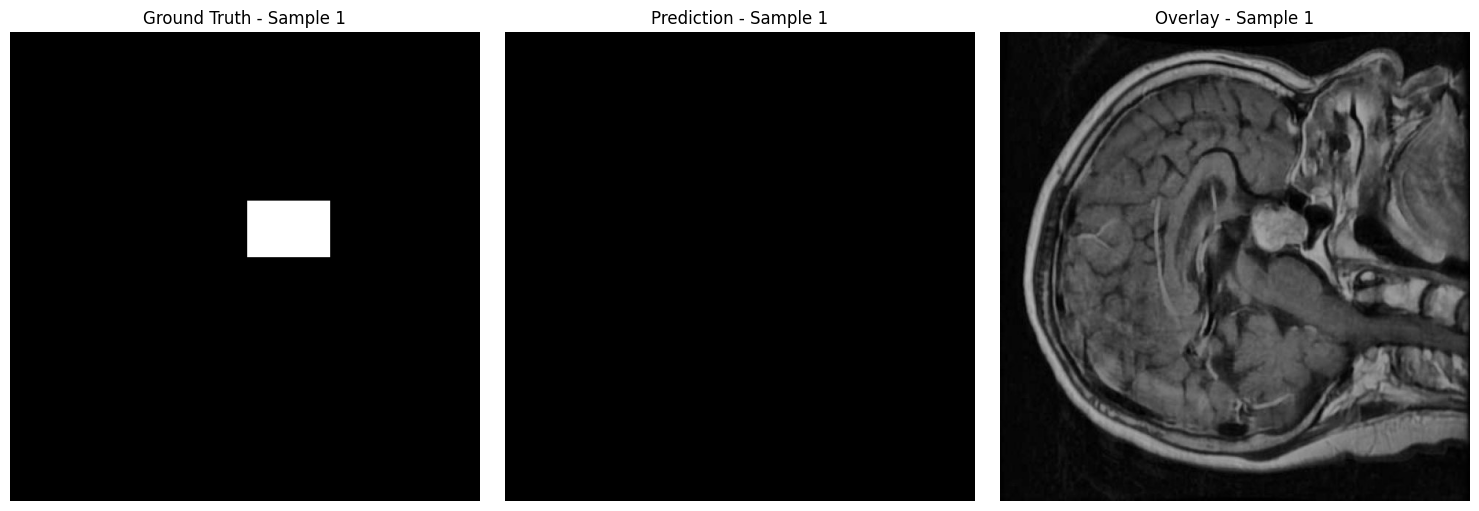

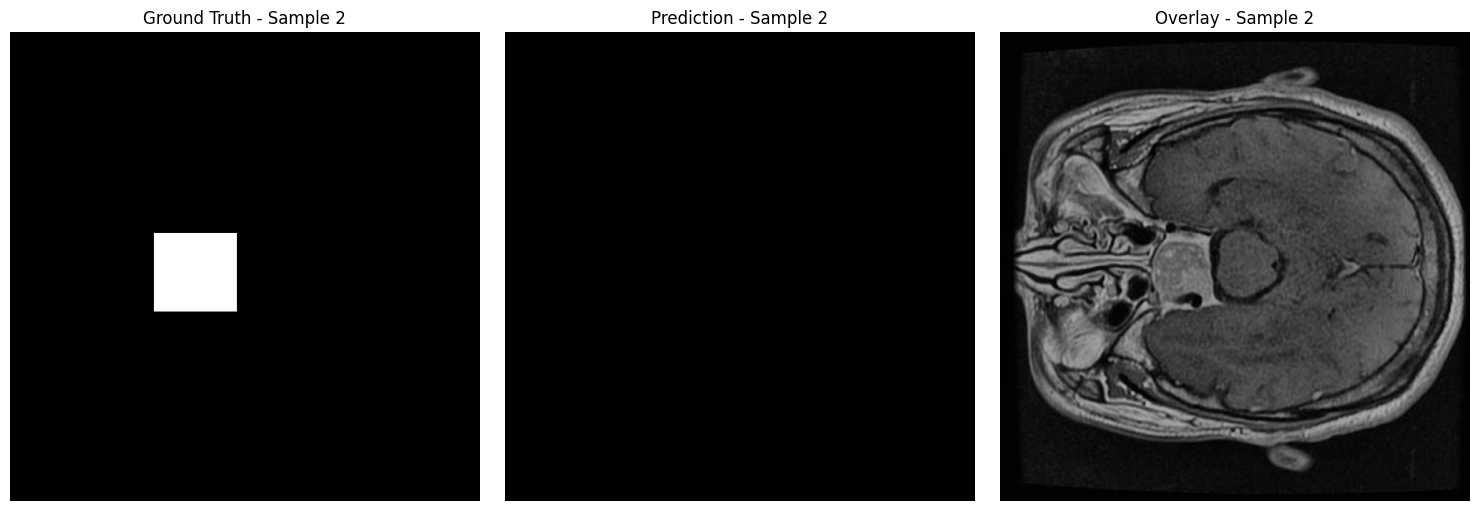

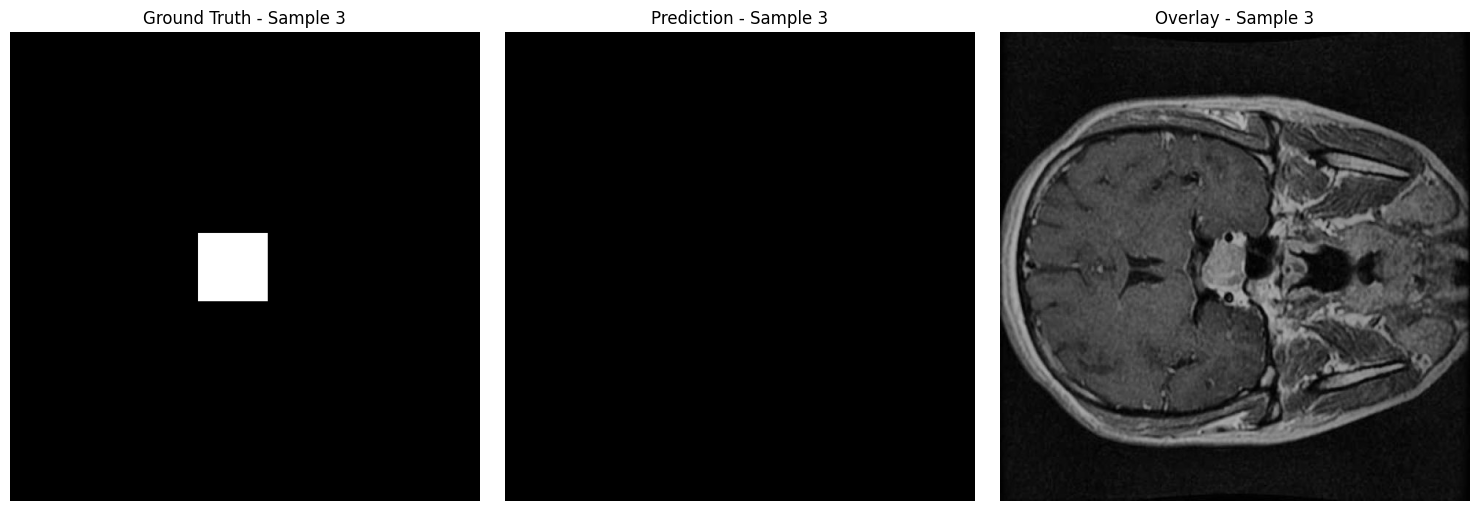

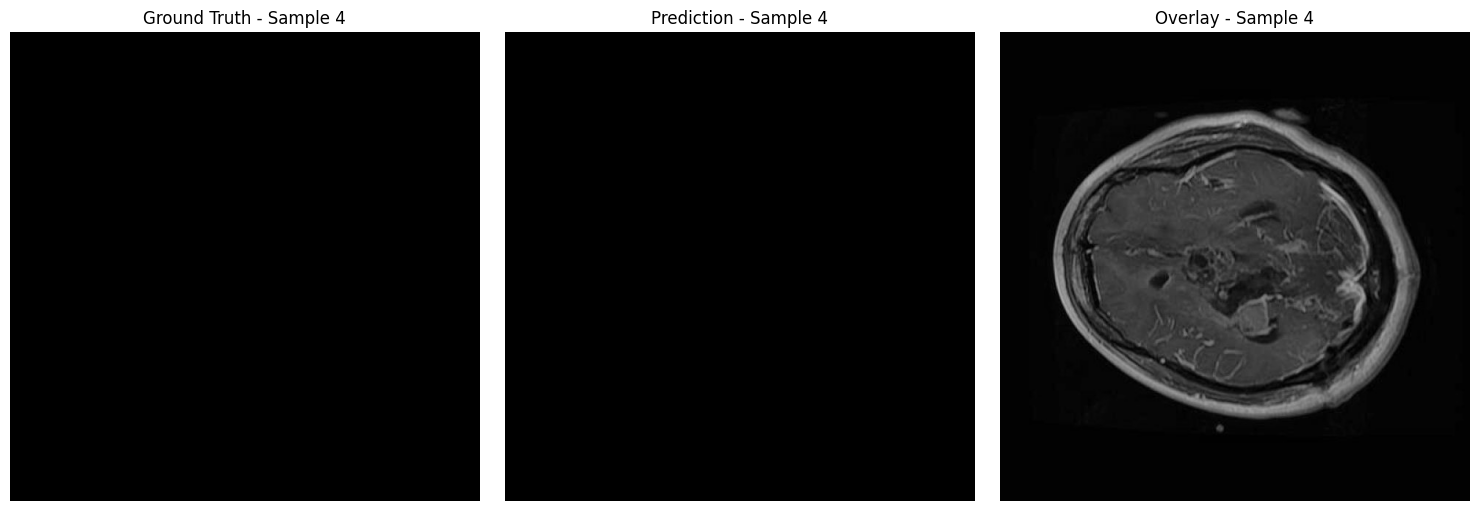

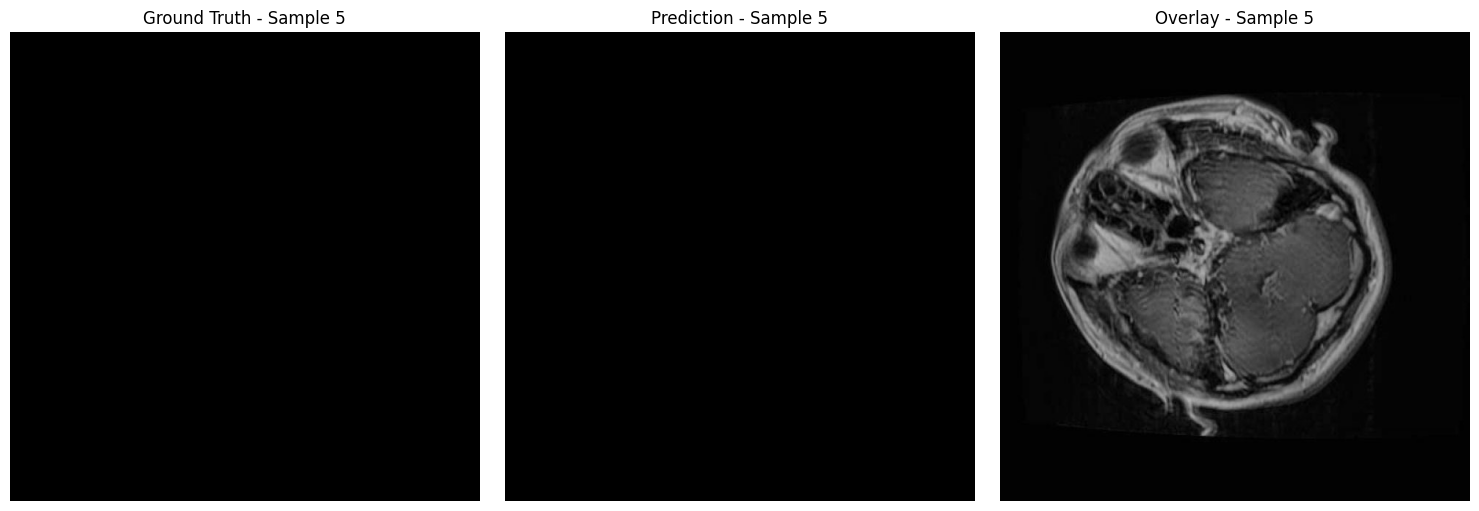

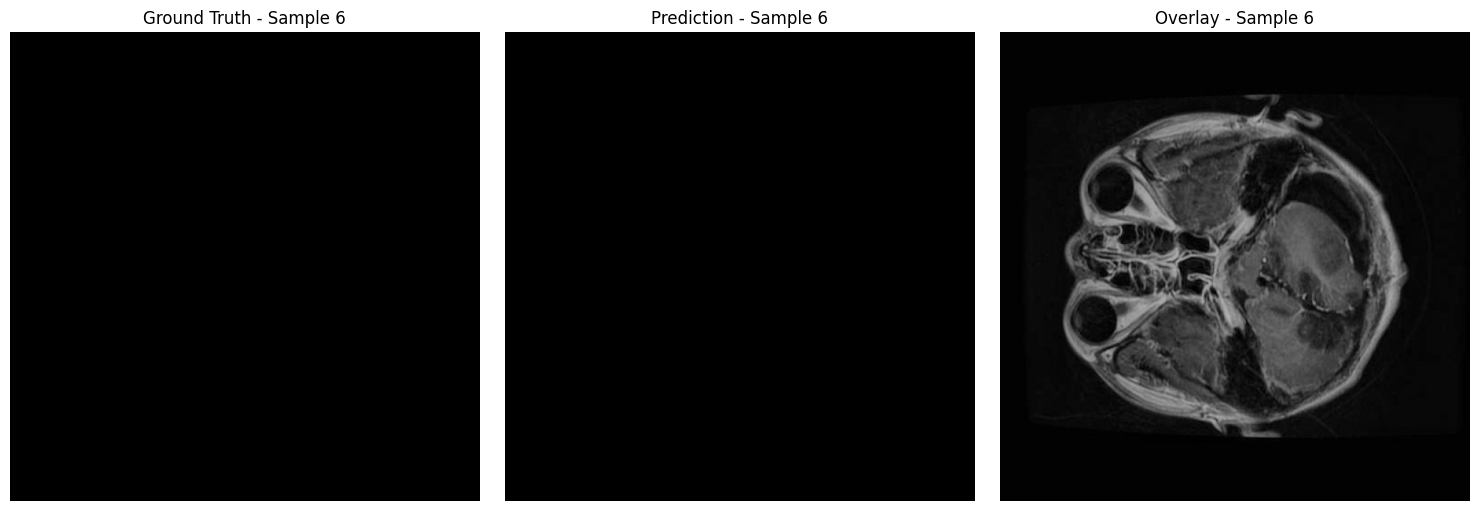

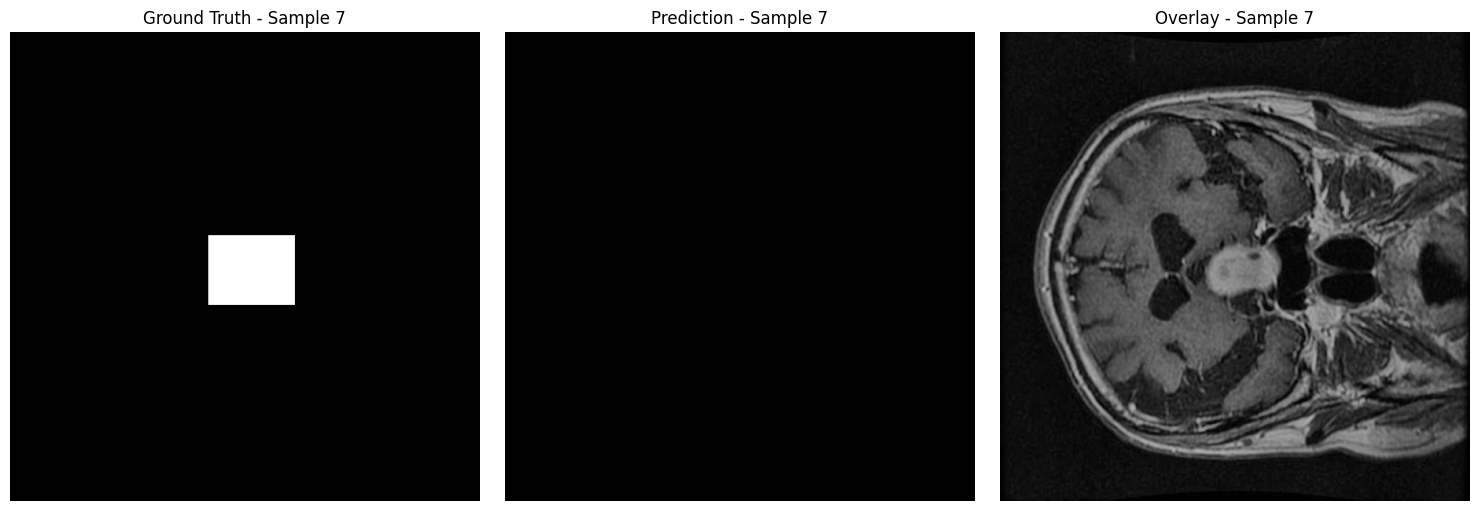

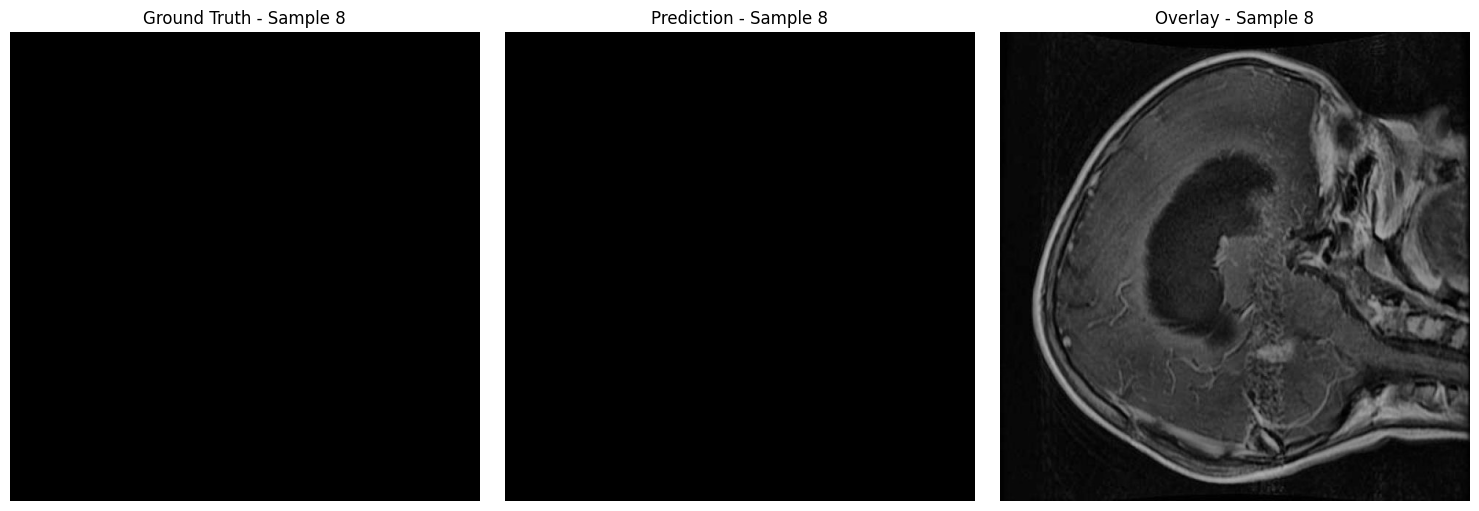

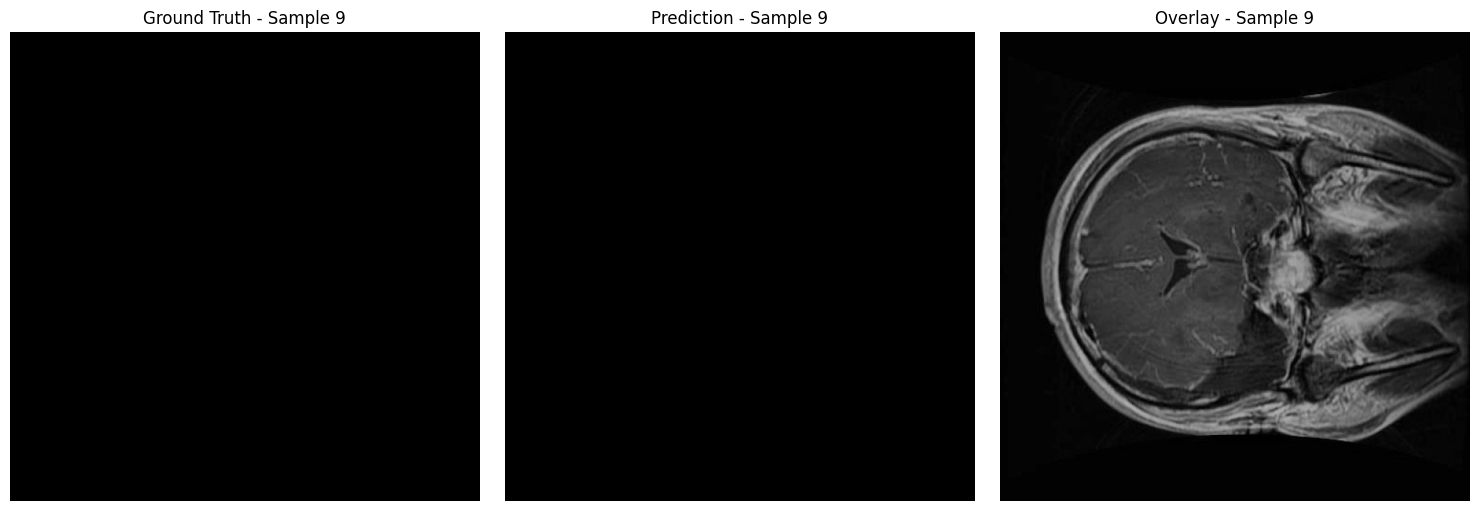

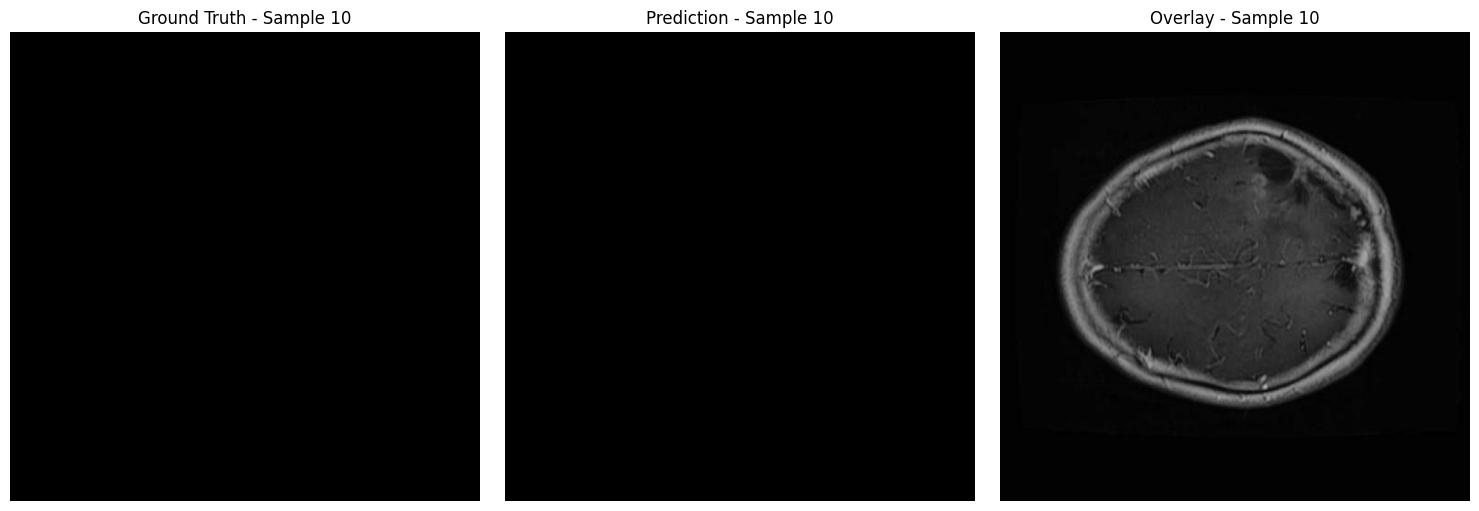

In [ ]:
visualize_predictions(test_dataset, preds, gt_masks, num_samples=5)


In [343]:
train_[40]["mask"].dtype

torch.int64